In [1]:
%reload_ext autoreload
%autoreload 2

import logging
import numpy as np

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

In [2]:
from replay_trajectory_classification.simulate import simulate_neuron_with_place_field
from track_linearization import get_linearized_position
from replay_trajectory_classification import make_track_graph
import numpy as np


def generate_position(traversal_path, track_graph, step_size=0.020, n_traversals=5):
    points = []
    for _ in range(n_traversals):
        for node1, node2 in traversal_path:
            x1, y1 = track_graph.nodes[node1]['pos']
            x2, y2 = track_graph.nodes[node2]['pos']
            dx, dy = x2 - x1, y2 - y1
            dist = np.sqrt(dx**2 + dy**2)
            n_points = int(dist // step_size)
            w = np.linspace(0, 1, n_points)
            points.append((x1 + dx * w, y1 + dy * w))

    return np.concatenate(points, axis=1).T

def get_unique_place_field_centers(place_field_centers):
    return np.unique((place_field_centers * 10_000).astype(int), axis=0) / 10_000

def make_two_environment_data():
    node_positions1 = [(40, 80), # 0
                       (40, 0),  # 1
                       (0, 0),   # 2
                       (0, 80),  # 3
                       (80, 0),  # 4
                       (80, 80), # 5
                       ]

    node_positions2 = [(80, 40),
                       (0, 40),
                       (0, 80),
                       (80, 80),
                       (0, 0),
                       (80, 0),
                       ]
    edges = [(0, 1),
             (1, 2),
             (2, 3),
             (1, 4),
             (4, 5)
            ]

    track_graph1 = make_track_graph(node_positions1, edges)
    track_graph2 = make_track_graph(node_positions2, edges)
    
    traversal_path = [(0, 1), (1, 2), (2, 3), (3, 2), (2, 1), (1, 0), (0, 1), (1, 4), (4, 5), (5, 4), (4, 1), (1, 0)]
    position1 = generate_position(traversal_path, track_graph1)
    position2 = generate_position(traversal_path, track_graph2)
    
    edge_order = ((0, 1),
                  (1, 2),
                  (2, 3),
                  (1, 4),
                  (4, 5)
                 )
    edge_spacing = (30, 0, 30, 0)
    position_df1 = get_linearized_position(position1,
                                           track_graph1,
                                           edge_order=edge_order,
                                           edge_spacing=edge_spacing,
                                           use_HMM=False)
    position_df2 = get_linearized_position(position2,
                                          track_graph2,
                                          edge_order=edge_order,
                                          edge_spacing=edge_spacing,
                                          use_HMM=False)
    
    sampling_frequency = 1000

    place_field_centers1 = generate_position(traversal_path, track_graph1, step_size=10, n_traversals=1)
    place_field_centers1 = get_unique_place_field_centers(place_field_centers1)
    
    spikes1 = np.stack([simulate_neuron_with_place_field(center, position1,
                                                        sampling_frequency=sampling_frequency,
                                                        variance=6.0**2)
                       for center in place_field_centers1], axis=1)
    
    place_field_centers2 = generate_position(traversal_path, track_graph2, step_size=10, n_traversals=1)
    place_field_centers2 = get_unique_place_field_centers(place_field_centers2)
    # randomize place fields so they don't overlap too much between environments
    # ind = np.arange(28)
    # np.random.shuffle(ind)
    # place_field_centers2 = place_field_centers2[ind]

    
    spikes2 = np.stack([simulate_neuron_with_place_field(center, position2,
                                                    sampling_frequency=sampling_frequency,
                                                    variance=6.0**2)
                   for center in place_field_centers2], axis=1)
    
    return (spikes1, spikes2,
            position_df1, position_df2,
            track_graph1, track_graph2, 
            place_field_centers1, place_field_centers2,
            position1, position2,
            edge_order, edge_spacing
           )

In [3]:
(spikes1, spikes2,
 position_df1, position_df2,
 track_graph1, track_graph2, 
 place_field_centers1, place_field_centers2,
 position1, position2,
 edge_order, edge_spacing
) = make_two_environment_data()

Text(0.5, 0, 'X-Position')

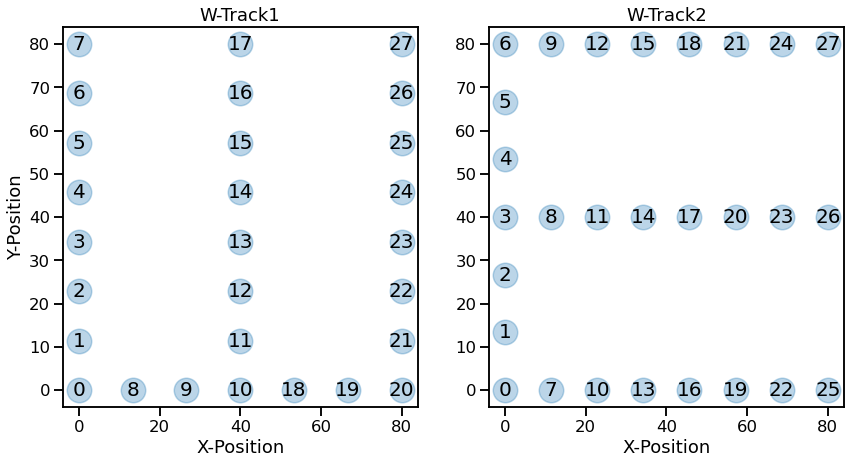

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0.3, s=600, zorder=0)
for ind, center in enumerate(place_field_centers1):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20, zorder=1)
axes[0].set_title('W-Track1')
axes[0].set_ylabel('Y-Position')
axes[0].set_xlabel('X-Position')
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0.3, s=600, zorder=0)
for ind, center in enumerate(place_field_centers2):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20, zorder=1)
axes[1].set_title('W-Track2')
axes[1].set_xlabel('X-Position')

(-8.4, 88.4, -8.4, 88.4)

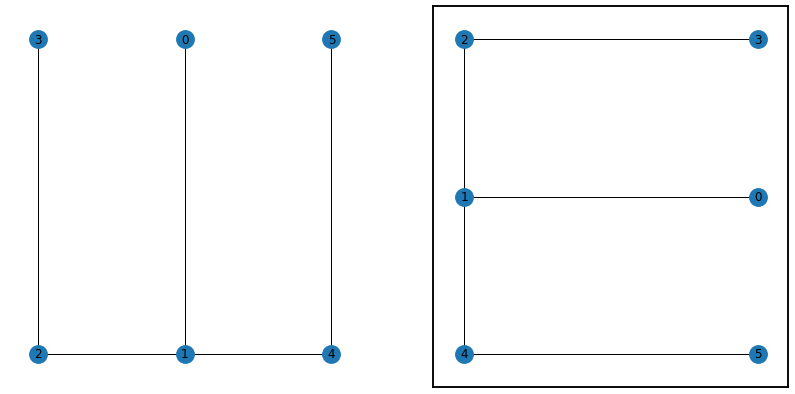

In [5]:
from track_linearization import plot_track_graph

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
plot_track_graph(track_graph1, ax=axes[0])
plot_track_graph(track_graph2, ax=axes[1])
axes[0].axis('off')

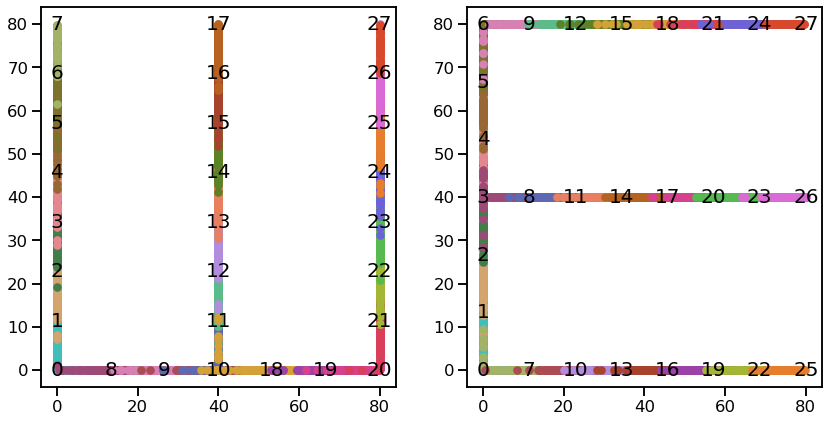

In [6]:
colors = ["#609ed8",
"#3fbfbc",
"#d4a46d",
"#427d4a",
"#e5878e",
"#996733",
"#7c722b",
"#a2b367",
"#9e4a76",
"#d680b4",
"#ab4b54",
"#5f69b3",
"#5bbc89",
"#b28cdd",
"#e77f60",
"#5b8225",
"#a7432c",
"#b66221",
"#d4a038",
"#9a42a8",
"#d6418d",
"#db3e5b",
"#a3b734",
"#56ba50",
"#6d63d7",
"#e67e2d",
"#d96ad6",
"#d8492c"]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0)
for ind, (center, spike) in enumerate(zip(place_field_centers1, spikes1.T)):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)
    axes[0].scatter(position1[spike.astype(bool), 0], position1[spike.astype(bool), 1], c=colors[ind], s=50)
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0)
for ind, (center, spike) in enumerate(zip(place_field_centers2, spikes2.T)):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)
    axes[1].scatter(position2[spike.astype(bool), 0], position2[spike.astype(bool), 1], c=colors[ind], s=50)

In [7]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 376.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42181,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 376.59 GiB
Comm: tcp://127.0.0.1:45325,Total threads: 7
Dashboard: http://127.0.0.1:33075/status,Memory: 47.07 GiB
Nanny: tcp://127.0.0.1:34477,


In [8]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform
from replay_trajectory_classification.observation_model import ObservationModel

environments = (
    Environment('wtrack1', track_graph=track_graph1, edge_order=edge_order, edge_spacing=edge_spacing),
    Environment('wtrack2', track_graph=track_graph2, edge_order=edge_order, edge_spacing=edge_spacing))

continuous_transition_types = [[RandomWalk('wtrack1'),         Uniform('wtrack1', 'wtrack2')],
                               [Uniform('wtrack2', 'wtrack1'), RandomWalk('wtrack2')]]

environment_names_to_state = ['wtrack1', 'wtrack2']
observation_models = [ObservationModel('wtrack1'), ObservationModel('wtrack2')]

classifier = SortedSpikesClassifier(
    environments=environments,
    observation_models=observation_models,
    continuous_transition_types=continuous_transition_types,
)
classifier

SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack1', movement_var=6.0, movement_mean=0.0),
                                                     Uniform(environment_name='wtrack1', environment2_name='wtrack2')],
                                                    [Uniform(environment_name='wtrack2', environment2_name='wtrack1'),
                                                     RandomWalk(environment_name='wtrack2', movement_var=6.0, movement_mean=0.0)]],
                       discrete_transiti...
                                     Environment(environment_name='wtrack2', place_bin_size=2.0, track_graph=<networkx.classes.graph.Graph object at 0x7fb3af356250>, edge_order=((0, 1), (1, 2), (2, 3), (1, 4), (4, 5)), edge_spacing=(30, 0, 30, 0), is_track_interior=None, position_range=None, infer_track_interior=True)),
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
        

In [9]:
position = np.concatenate((position_df1.linear_position.values,
                           position_df2.linear_position.values))
spikes = np.concatenate((spikes1, spikes2))
environment_labels = np.concatenate((['wtrack1'] * spikes1.shape[0],
                                     ['wtrack2'] * spikes2.shape[0],
                                    ))
classifier.fit(
    position=position,
    spikes=spikes,
    environment_labels=environment_labels,
)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack1', movement_var=6.0, movement_mean=0.0),
                                                     Uniform(environment_name='wtrack1', environment2_name='wtrack2')],
                                                    [Uniform(environment_name='wtrack2', environment2_name='wtrack1'),
                                                     RandomWalk(environment_name='wtrack2', movement_var=6.0, movement_mean=0.0)]],
                       discrete_transiti...
                                     Environment(environment_name='wtrack2', place_bin_size=2.0, track_graph=<networkx.classes.graph.Graph object at 0x7fb3af356250>, edge_order=((0, 1), (1, 2), (2, 3), (1, 4), (4, 5)), edge_spacing=(30, 0, 30, 0), is_track_interior=None, position_range=None, infer_track_interior=True)),
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
        

In [13]:
def make_sequence(neuron_sequence, n_neurons=28, step=1):
    neuron_sequence = np.asarray(neuron_sequence)
    n_time = step * len(neuron_sequence)
    spike_time_ind = np.arange(0, n_time, step)
    spikes = np.zeros((n_time, n_neurons))
    
    spikes[(spike_time_ind, neuron_sequence)] = 1
    
    return spikes

In [14]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform

environments2 = (
    Environment('wtrack1', track_graph=track_graph1, edge_order=edge_order, edge_spacing=edge_spacing))

continuous_transition_types2 = [[RandomWalk('wtrack1'), Uniform('wtrack1')],
                                [Uniform('wtrack1'),    Uniform('wtrack1')]]

classifier2 = SortedSpikesClassifier(
    environments=environments2,
    continuous_transition_types=continuous_transition_types2,
)
classifier2.fit(
    position=position_df1.linear_position.values,
    spikes=spikes1,
)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack1', movement_var=6.0, movement_mean=0.0),
                                                     Uniform(environment_name='wtrack1', environment2_name=None)],
                                                    [Uniform(environment_name='wtrack1', environment2_name=None),
                                                     Uniform(environment_name='wtrack1', environment2_name=None)]],
                       discrete_transition_type=DiagonalDiscrete(...
                       environments=(Environment(environment_name='wtrack1', place_bin_size=2.0, track_graph=<networkx.classes.graph.Graph object at 0x7fb3af356550>, edge_order=((0, 1), (1, 2), (2, 3), (1, 4), (4, 5)), edge_spacing=(30, 0, 30, 0), is_track_interior=None, position_range=None, infer_track_interior=True),),
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
        

In [15]:
def plot_one_env_results(results):
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(7, 8 / 2), sharex=True)
    (results
     .acausal_posterior
     .sum('position')
     .assign_coords(time=lambda ds: ds.time / 1000)
     .plot(x='time', hue='state', ax=ax))
    ax.set_ylim((0, 1))
    ax.set_xlim((results.time[0] / 1000, results.time[-1] / 1000))
    ax.set_ylabel('Prob.')
    sns.despine()

In [16]:
import copy
from cycler import cycler

def plot_replay_results(test_spikes, classifier, results):
    time = np.arange(test_spikes.shape[0]) / 1000
    fig, axes = plt.subplots(4, 1, constrained_layout=True, figsize=(7, 8), sharex=True)
    time_ind, spike_ind = np.nonzero(test_spikes)
    mask1 = ~classifier.environments[0].is_track_interior_
    mask1 = mask1.astype(float)
    mask1[mask1 == 1] = np.nan
    mask1[mask1 == 0] = 1
    mask1 = mask1[:, np.newaxis]

    mask2 = ~classifier.environments[1].is_track_interior_
    mask2 = mask2.astype(float)
    mask2[mask2 == 1] = np.nan
    mask2[mask2 == 0] = 1
    mask2 = mask2[:, np.newaxis]

    cmap = copy.copy(plt.cm.get_cmap('bone_r'))
    cmap.set_bad(color="lightgrey", alpha=0.8)
    
    axes[0].scatter(time[time_ind], spike_ind, clip_on=False, color='black', s=50)
    axes[0].set_ylim((0, 28))
    axes[0].set_ylabel('Cells')
    
    t, x = np.meshgrid(time, classifier.environments[0].edges_[0])
    axes[1].pcolormesh(t, x, results['acausal_posterior'][:, 0].T * mask1,
                       cmap=cmap, vmin=0.0, vmax=0.1)
    axes[1].set_title('W-Track1')
    axes[1].set_ylabel('Position')    
    
    t, x = np.meshgrid(time, classifier.environments[1].edges_[0])
    axes[2].pcolormesh(t, x, results['acausal_posterior'][:, 1].T * mask2,
                       cmap=cmap, vmin=0.0, vmax=0.1)
    axes[2].set_title('W-Track2')
    axes[2].set_ylabel('Position') 
    
    
    axes[3].set_prop_cycle(cycler(color=['r', 'g', 'b', 'y']))
    axes[3].plot(time, results['acausal_posterior'].sum(axis=2),
                 label=['wtrack1', 'wtrack2'])
    axes[3].set_ylim((0, 1))
    axes[3].set_ylabel('Prob.')
    axes[3].set_xlabel('Time')
    axes[3].legend()
    sns.despine()

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


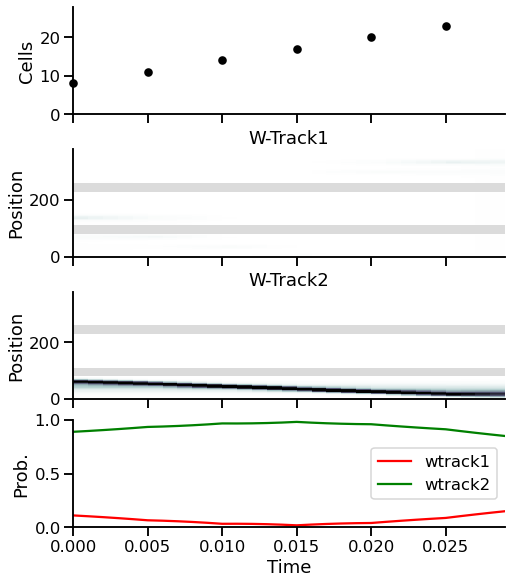

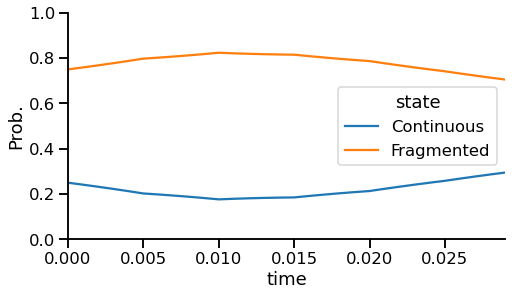

In [17]:
test_spikes = make_sequence([8, 11, 14, 17, 20, 23], 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_one_env_results(results2)

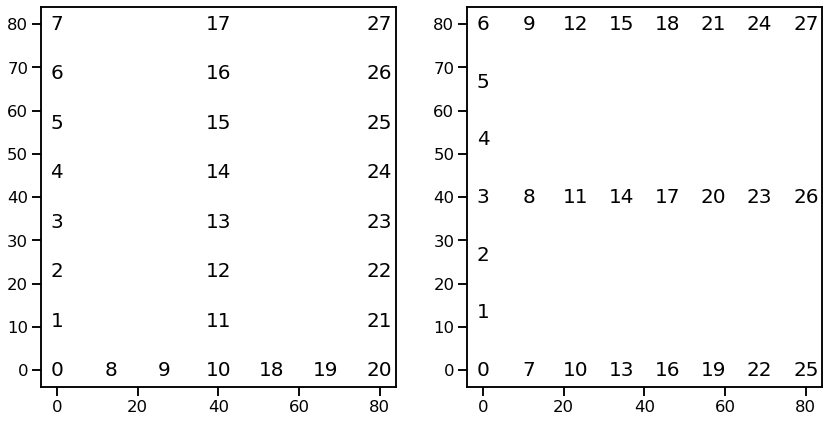

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers1):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers2):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


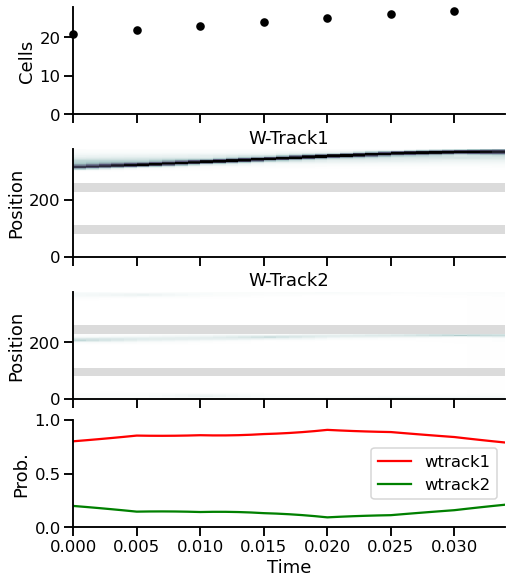

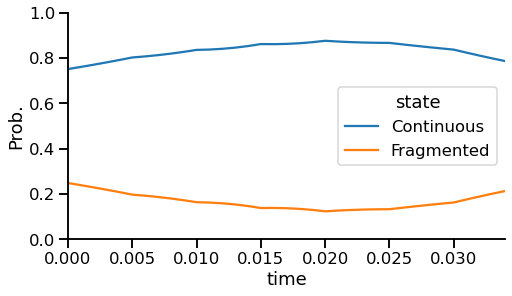

In [19]:
test_spikes = make_sequence([21, 22, 23, 24, 25, 26, 27], 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_one_env_results(results2)

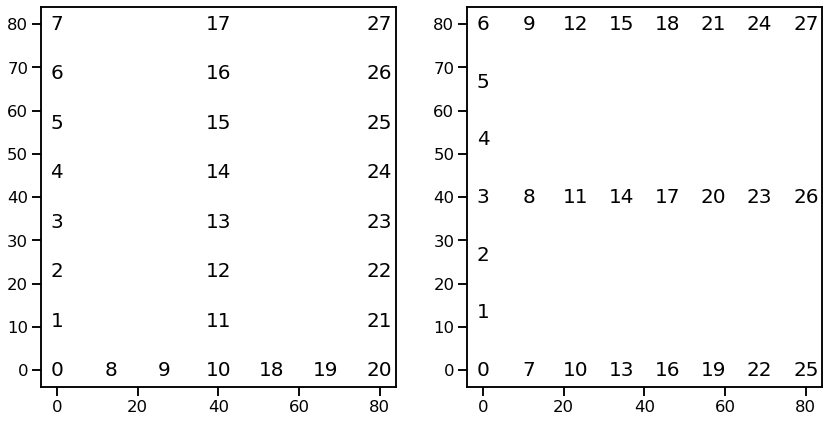

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers1):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers2):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


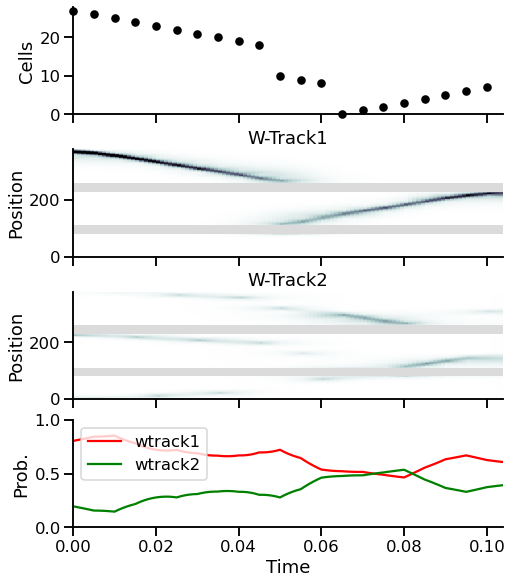

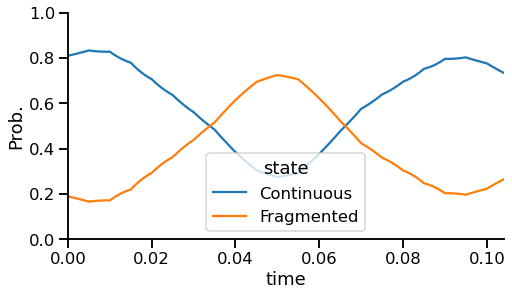

In [21]:
test_spikes = make_sequence([27,  26, 25, 24, 23, 22, 21, 20, 19, 18, 10, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7], 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_one_env_results(results2)

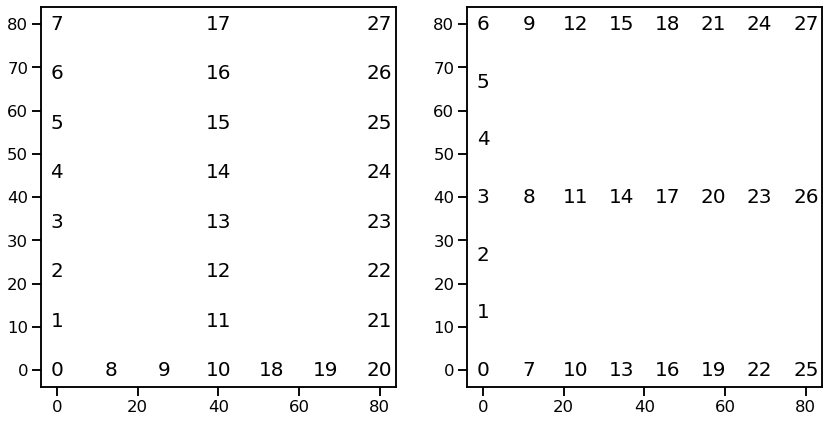

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers1):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers2):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


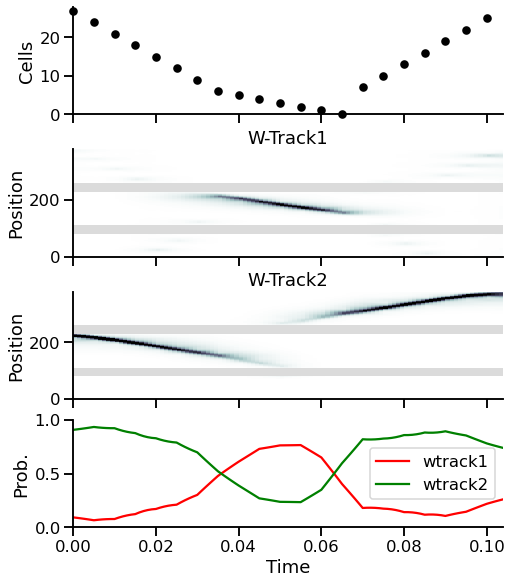

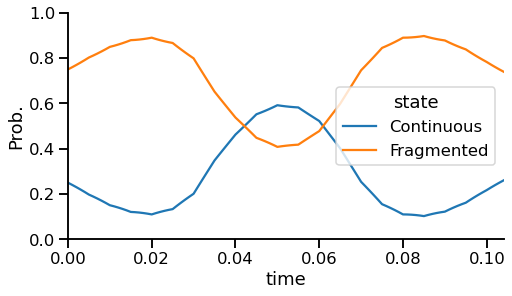

In [23]:
test_spikes = make_sequence([27, 24, 21, 18, 15, 12, 9, 6, 5, 4, 3, 2, 1, 0, 7, 10, 13, 16, 19, 22, 25], 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_one_env_results(results2)

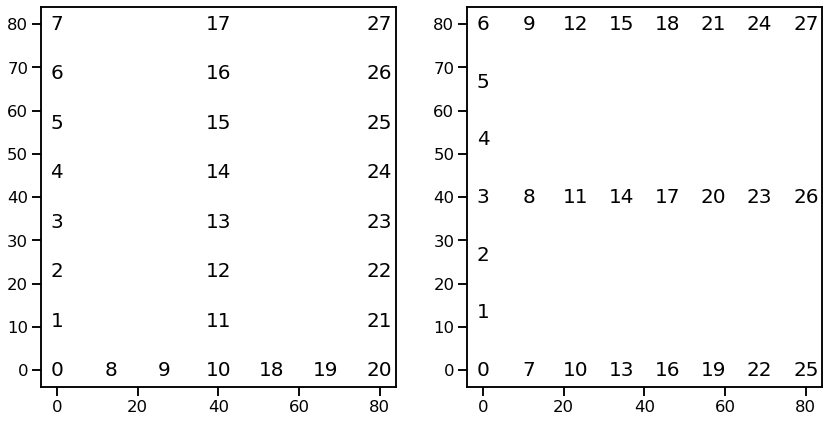

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers1):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers2):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


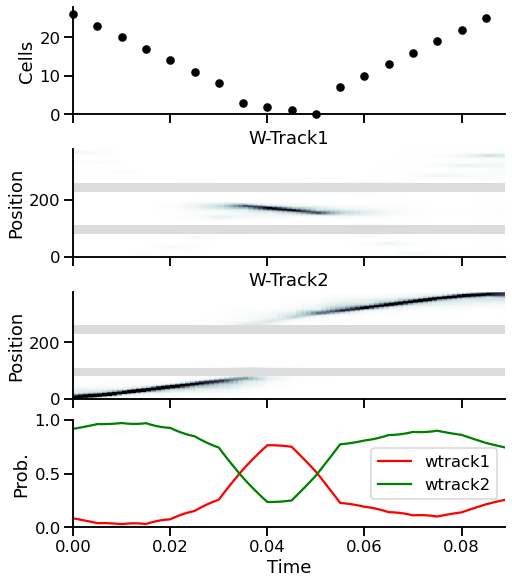

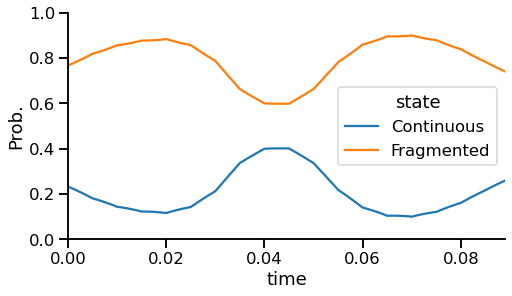

In [25]:
test_spikes = make_sequence([26, 23, 20, 17, 14, 11, 8, 3, 2, 1, 0, 7, 10, 13, 16, 19, 22, 25], 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_one_env_results(results2)

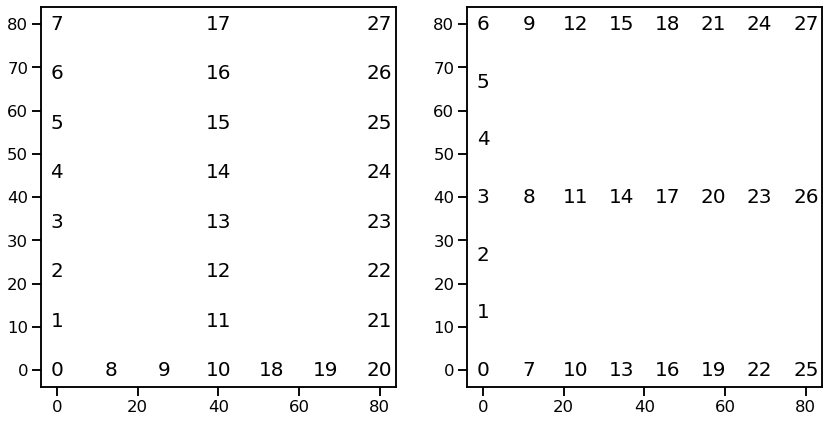

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers1):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers2):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


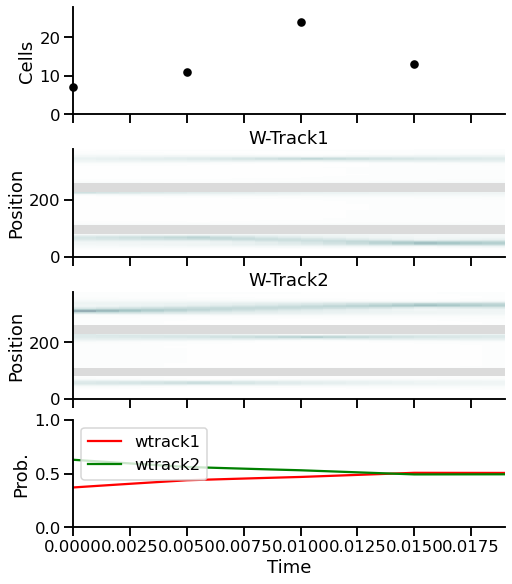

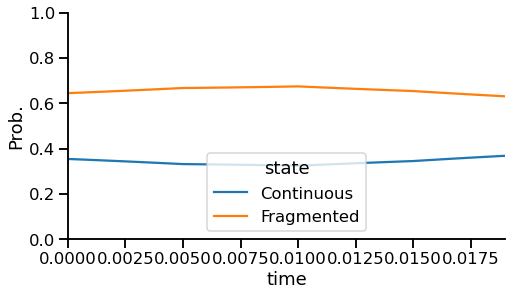

In [27]:
test_spikes = make_sequence([7, 11, 24, 13], 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_one_env_results(results2)

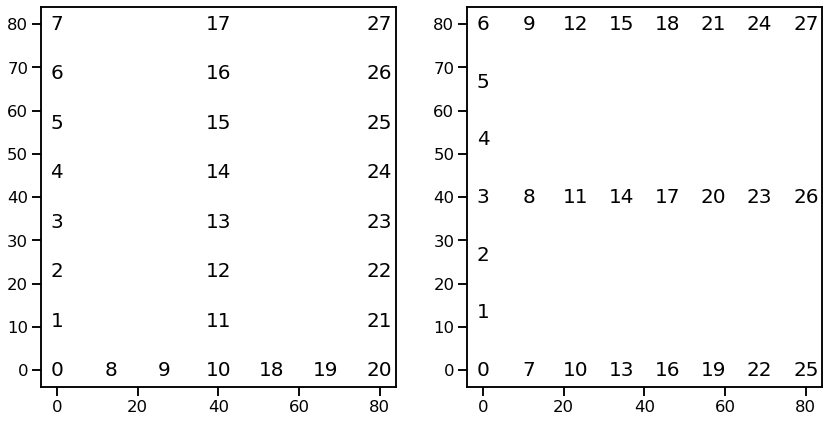

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers1):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers2):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


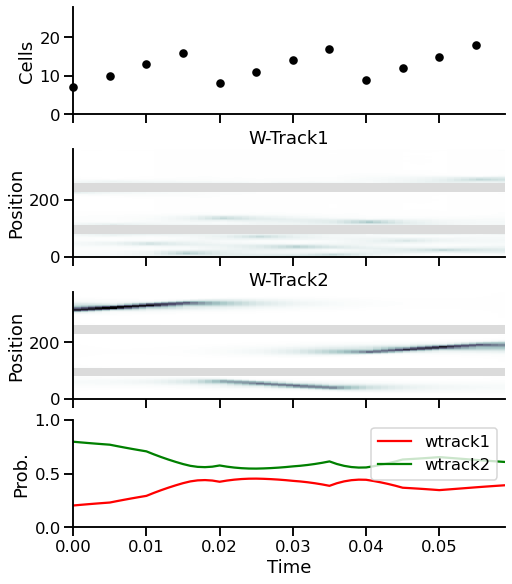

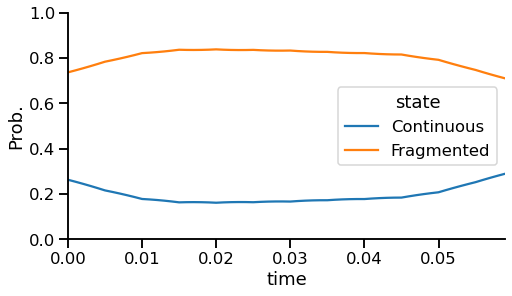

In [29]:
test_spikes = make_sequence([7, 10, 13, 16, 8, 11, 14, 17, 9, 12, 15, 18], 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_one_env_results(results2)

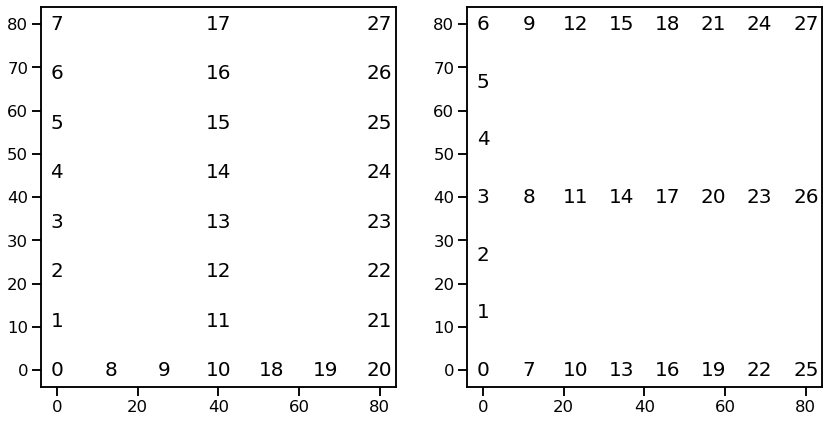

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers1):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0)
for ind, center in enumerate(place_field_centers2):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


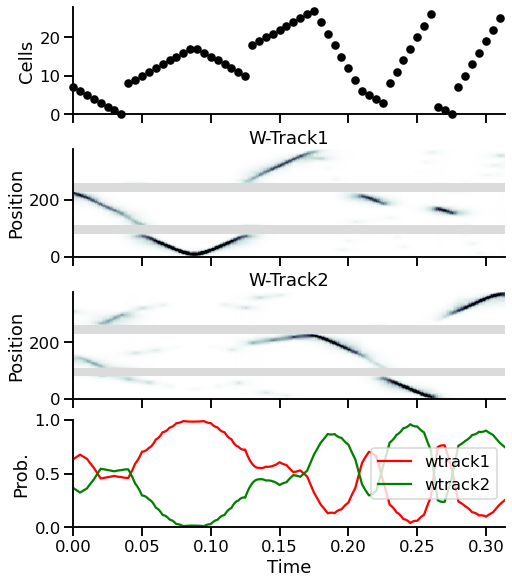

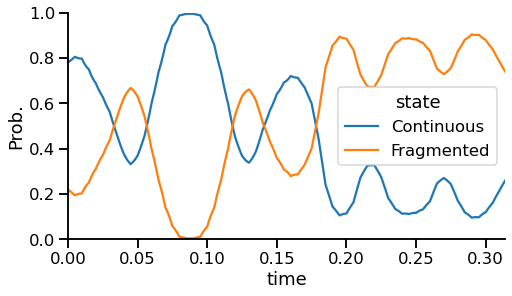

In [31]:
test_spikes = make_sequence([7, 6, 5, 4, 3, 2, 1, 0, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                             17, 16, 15, 14, 13, 12, 11, 10, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
                             24, 21, 18, 15, 12, 9, 6, 5, 4, 3, 8, 11, 14, 17, 20, 23, 26, 2, 1, 0,
                             7, 10, 13, 16, 19, 22, 25], 28, 5)

results = classifier.predict(test_spikes)
results2 = classifier2.predict(test_spikes, state_names=['Continuous', 'Fragmented'])

plot_replay_results(test_spikes, classifier, results)
plot_one_env_results(results2)